## imports

In [1]:
!pip install finance-datareader -q

     |████████████████████████████████| 48 kB 1.8 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import FinanceDataReader as fdr

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
USD_KRX = fdr.DataReader('USD/KRW', start='2016', end='2022-06-08')
USD_KRX.head()

,Close,Open,High,Low,Change
Date,,,,,
2016-01-01,1175.45,1175.94,1176.50,1175.19,-0.0004
2016-01-04,1190.35,1175.66,1193.23,1175.65,0.0127
2016-01-05,1190.81,1190.35,1192.80,1184.40,0.0004
2016-01-06,1200.52,1190.81,1203.80,1187.59,0.0082
2016-01-07,1197.29,1200.52,1204.70,1193.16,-0.0027


In [4]:
# Change는 사용하지 않을 것이므로 해당 열을 삭제해주도록 한다
USD_KRX.drop('Change', axis=1, inplace=True)

In [5]:
USD_KRX.head()

,Close,Open,High,Low
Date,,,,
2016-01-01,1175.45,1175.94,1176.50,1175.19
2016-01-04,1190.35,1175.66,1193.23,1175.65
2016-01-05,1190.81,1190.35,1192.80,1184.40
2016-01-06,1200.52,1190.81,1203.80,1187.59
2016-01-07,1197.29,1200.52,1204.70,1193.16


## Simple EDA and preprocessing

In [6]:
print(f"Shape of the data:{USD_KRX.shape}")

Shape of the data:(1679, 4)


In [7]:
USD_KRX.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1679 entries, 2016-01-01 to 2022-06-08
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1679 non-null   float64
 1   Open    1679 non-null   float64
 2   High    1679 non-null   float64
 3   Low     1679 non-null   float64
dtypes: float64(4)
memory usage: 65.6 KB


In [8]:
USD_KRX.describe()

,Close,Open,High,Low
count,1679.000000,1679.000000,1679.000000,1679.000000
mean,1151.968350,1152.187493,1157.100721,1147.784008
std,44.894887,44.953062,45.449847,44.618971
min,1054.940000,1054.940000,1060.100000,1053.000000
25%,1120.120000,1120.120000,1125.405000,1116.590000
50%,1144.970000,1145.230000,1150.000000,1141.090000
75%,1186.080000,1186.640000,1190.775000,1182.785000
max,1290.720000,1290.870000,1293.140000,1278.470000


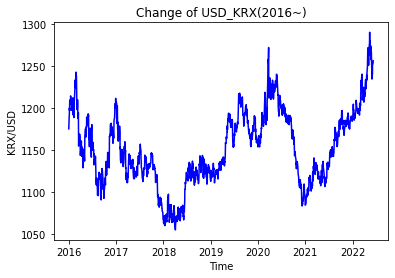

In [9]:
plt.plot(USD_KRX.Close, color='blue')
plt.title('Change of USD_KRX(2016~)')
plt.xlabel('Time')
plt.ylabel("KRX/USD")
plt.show()

In [ ]:
# divide the dataset into training and test sets
train = USD_KRX[USD_KRX.index < '2021-06-01']
test = USD_KRX[USD_KRX.index >= '2021-06-01']
print(f'shape of train: {train.shape}')
print(f'shape of test: {test.shape}')

shape of train: (1412, 4)
shape of test: (267, 4)


In [ ]:
scaler_1 = MinMaxScaler()
scaler_target = MinMaxScaler()

train[['Open', 'High', 'Low']] = scaler_1.fit_transform(train[['Open', 'High', 'Low']])
test[['Open', 'High', 'Low']] = scaler_1.transform(test[['Open', 'High', 'Low']])

train[['Close']] = scaler_target.fit_transform(train[['Close']])
test[['Close']] = scaler_target.fit_transform(test[['Close']])

## Building LSTM model 1

### preprocessing the data

In [ ]:
# Creating a data structure with 15 timesteps and 1 output
X_train = []
y_train = []
for i in range(15, len(train)):
  X_train.append(train.iloc[i-15:i,0])
  y_train.append(train.iloc[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1397, 15, 1)

### Building model

In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization

In [ ]:
# Initialising the RNN
regressor = Sequential()

# Initialising the RNN
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 10, activation='relu', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 10, activation='relu', return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 10, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 10, activation='relu'))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = 1))

In [ ]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 50, batch_size = 32)

Epoch 1/50
44/44 [==============================] - 9s 44ms/step - loss: 0.1379
Epoch 2/50
44/44 [==============================] - 2s 49ms/step - loss: 0.0404
Epoch 3/50
44/44 [==============================] - 2s 45ms/step - loss: 0.0260
Epoch 4/50
44/44 [==============================] - 2s 43ms/step - loss: 0.0217
Epoch 5/50
44/44 [==============================] - 2s 51ms/step - loss: 0.0184
Epoch 6/50
44/44 [==============================] - 2s 55ms/step - loss: 0.0170
Epoch 7/50
44/44 [==============================] - 2s 55ms/step - loss: 0.0184
Epoch 8/50
44/44 [==============================] - 2s 46ms/step - loss: 0.0156
Epoch 9/50
44/44 [==============================] - 2s 53ms/step - loss: 0.0145
Epoch 10/50
44/44 [==============================] - 2s 49ms/step - loss: 0.0143
Epoch 11/50
44/44 [==============================] - 2s 44ms/step - loss: 0.0134
Epoch 12/50
44/44 [==============================] - 2s 40ms/step - loss: 0.0133
Epoch 13/50
44/44 [==================

In [ ]:
# preprocessing the test dataset
# Creating a data structure with 15 timesteps
total_data = np.concatenate([train, test], axis=0)

X_test = []
for i in range(len(total_data)-len(test), len(total_data)):
  X_test.append(total_data[i-15:i,0])
X_test = np.array(X_test)

# Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(267, 15, 1)

In [ ]:
# 이전에 지정해주었던 test를 y_test로 사용하기로 한다.(Scaling은 되어 있음)
y_test = np.reshape(np.array(test.iloc[:,0]), (-1,1))
print(f"shape of X_test: {X_test.shape}")
print(f"shpa of y_test: {y_test.shape}")

shape of X_test: (267, 15, 1)
shpa of y_test: (267, 1)


In [ ]:
real_currency_rate = y_test
predicted_currency_rate_15 = regressor.predict(X_test)

print(mean_squared_error(real_currency_rate, predicted_currency_rate_15))

0.02283830428849713


In [ ]:
real_currency_rate = scaler_target.inverse_transform(real_currency_rate)
predicted_currency_rate_15 = scaler_target.inverse_transform(predicted_currency_rate_15)

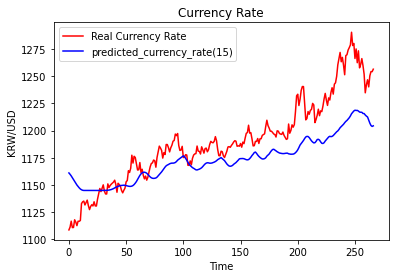

In [ ]:
# Visualising the results
plt.plot(real_currency_rate, color = 'red', label = 'Real Currency Rate')
plt.plot(predicted_currency_rate_15, color = 'blue', label = 'predicted_currency_rate(15)')
plt.title('Currency Rate')
plt.xlabel('Time')
plt.ylabel("KRW/USD")
plt.legend(loc='best')
plt.show()

## Building LSTM model 2

In [ ]:
# Creating a data structure with 15 timesteps and 1 output
X_train = []
y_train = []
for i in range(15, len(train)):
  X_train.append(train.iloc[i-15:i,:])
  y_train.append(train.iloc[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))
X_train.shape

(1397, 15, 4)

In [ ]:
# Initialising the RNN
regressor = Sequential()

# Initialising the RNN
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 10, activation='relu', return_sequences = True, input_shape = (X_train.shape[1], 4)))
regressor.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 10, activation='relu', return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 10, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 10, activation='relu'))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = 1))

In [ ]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
44/44 [==============================] - 6s 26ms/step - loss: 0.1158
Epoch 2/100
44/44 [==============================] - 1s 26ms/step - loss: 0.0322
Epoch 3/100
44/44 [==============================] - 1s 27ms/step - loss: 0.0245
Epoch 4/100
44/44 [==============================] - 1s 27ms/step - loss: 0.0209
Epoch 5/100
44/44 [==============================] - 1s 26ms/step - loss: 0.0196
Epoch 6/100
44/44 [==============================] - 1s 26ms/step - loss: 0.0159
Epoch 7/100
44/44 [==============================] - 1s 27ms/step - loss: 0.0169
Epoch 8/100
44/44 [==============================] - 1s 27ms/step - loss: 0.0148
Epoch 9/100
44/44 [==============================] - 1s 27ms/step - loss: 0.0135
Epoch 10/100
44/44 [==============================] - 1s 27ms/step - loss: 0.0132
Epoch 11/100
44/44 [==============================] - 1s 26ms/step - loss: 0.0128
Epoch 12/100
44/44 [==============================] - 1s 27ms/step - loss: 0.0105
Epoch 13/100
44/44 [=====

In [ ]:
# preprocessing the test dataset
# Creating a data structure with 15 timesteps
total_data = np.concatenate([train, test], axis=0)

X_test = []
for i in range(len(total_data)-len(test), len(total_data)):
  X_test.append(total_data[i-15:i,:])
X_test = np.array(X_test)

# Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 4))
X_test.shape

(267, 15, 4)

In [ ]:
# 이전에 지정해주었던 test를 y_test로 사용하기로 한다.(Scaling은 되어 있음)
y_test = np.reshape(np.array(test.iloc[:,0]), (-1,1))
print(f"shape of X_test: {X_test.shape}")
print(f"shpa of y_test: {y_test.shape}")

shape of X_test: (267, 15, 4)
shpa of y_test: (267, 1)


In [ ]:
real_currency_rate = y_test
predicted_currency_rate_15 = regressor.predict(X_test)

print(mean_squared_error(real_currency_rate, predicted_currency_rate_15))

0.00936039085797847


In [ ]:
real_currency_rate = scaler_target.inverse_transform(real_currency_rate)
predicted_currency_rate_15 = scaler_target.inverse_transform(predicted_currency_rate_15)

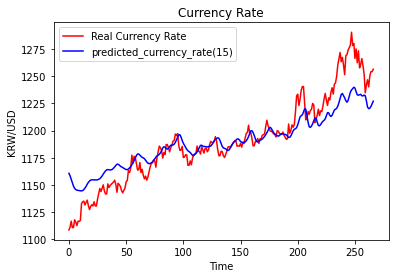

In [ ]:
# Visualising the results
plt.plot(real_currency_rate, color = 'red', label = 'Real Currency Rate')
plt.plot(predicted_currency_rate_15, color = 'blue', label = 'predicted_currency_rate(15)')
plt.title('Currency Rate')
plt.xlabel('Time')
plt.ylabel("KRW/USD")
plt.legend(loc='best')
plt.show()

## Building LSTM model 3

### preprocessing the data

In [ ]:
# Creating a data structure with 30 timesteps and 1 output
X_train = []
y_train = []
for i in range(30, len(train)):
  X_train.append(train.iloc[i-30:i,:])
  y_train.append(train.iloc[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))
X_train.shape

(1382, 30, 4)

### Building model

In [ ]:
# Initialising the RNN
regressor = Sequential()

# Initialising the RNN
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 20, activation='relu', return_sequences = True, input_shape = (X_train.shape[1], 4)))
regressor.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 20, activation='relu', return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 20, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 20, activation='relu'))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = 1))

In [ ]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
44/44 [==============================] - 7s 50ms/step - loss: 0.0936
Epoch 2/100
44/44 [==============================] - 2s 51ms/step - loss: 0.0191
Epoch 3/100
44/44 [==============================] - 2s 50ms/step - loss: 0.0151
Epoch 4/100
44/44 [==============================] - 2s 50ms/step - loss: 0.0153
Epoch 5/100
44/44 [==============================] - 2s 50ms/step - loss: 0.0139
Epoch 6/100
44/44 [==============================] - 2s 51ms/step - loss: 0.0131
Epoch 7/100
44/44 [==============================] - 2s 50ms/step - loss: 0.0128
Epoch 8/100
44/44 [==============================] - 2s 51ms/step - loss: 0.0117
Epoch 9/100
44/44 [==============================] - 2s 52ms/step - loss: 0.0114
Epoch 10/100
44/44 [==============================] - 3s 62ms/step - loss: 0.0104
Epoch 11/100
44/44 [==============================] - 3s 55ms/step - loss: 0.0104
Epoch 12/100
44/44 [==============================] - 2s 50ms/step - loss: 0.0100
Epoch 13/100
44/44 [=====

In [ ]:
# preprocessing the test dataset
# Creating a data structure with 30 timesteps
total_data = np.concatenate([train, test], axis=0)

X_test = []
for i in range(len(total_data)-len(test), len(total_data)):
  X_test.append(total_data[i-30:i,:])
X_test = np.array(X_test)

# Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 4))
X_test.shape

(267, 30, 4)

In [ ]:
# 이전에 지정해주었던 test를 y_test로 사용하기로 한다.(Scaling은 되어 있음)
y_test = np.reshape(np.array(test.iloc[:,0]), (-1,1))
print(f"shape of X_test: {X_test.shape}")
print(f"shpa of y_test: {y_test.shape}")

shape of X_test: (267, 30, 4)
shpa of y_test: (267, 1)


In [ ]:
real_currency_rate = y_test
predicted_currency_rate_30 = regressor.predict(X_test)

print(mean_squared_error(real_currency_rate, predicted_currency_rate_30))

0.008898842241881602


In [ ]:
real_currency_rate = scaler_target.inverse_transform(real_currency_rate)
predicted_currency_rate_30 = scaler_target.inverse_transform(predicted_currency_rate_30)

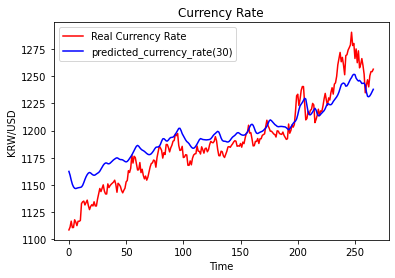

In [ ]:
# Visualising the results
plt.plot(real_currency_rate, color = 'red', label = 'Real Currency Rate')
plt.plot(predicted_currency_rate_30, color = 'blue', label = 'predicted_currency_rate(30)')
plt.title('Currency Rate')
plt.xlabel('Time')
plt.ylabel("KRW/USD")
plt.legend(loc='best')
plt.show()

## Building LSTM model 4

### preprocessing the data

In [ ]:
# Creating a data structure with 50 timesteps and 1 output
X_train = []
y_train = []
for i in range(50, len(train)):
  X_train.append(train.iloc[i-50:i,:])
  y_train.append(train.iloc[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))
X_train.shape

(1362, 50, 4)

### Building model

In [ ]:
# Initialising the RNN
regressor = Sequential()

# Initialising the RNN
regressor = Sequential()
# Adding the first LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 40, activation='relu', return_sequences = True, input_shape = (X_train.shape[1], 4)))
regressor.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 40, activation='relu', return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 40, activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularization
regressor.add(LSTM(units = 40, activation='relu'))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = 1))

In [ ]:
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
43/43 [==============================] - 9s 95ms/step - loss: 0.0471
Epoch 2/100
43/43 [==============================] - 4s 96ms/step - loss: 0.0141
Epoch 3/100
43/43 [==============================] - 4s 95ms/step - loss: 0.0102
Epoch 4/100
43/43 [==============================] - 4s 91ms/step - loss: 0.0096
Epoch 5/100
43/43 [==============================] - 4s 96ms/step - loss: 0.0094
Epoch 6/100
43/43 [==============================] - 4s 94ms/step - loss: 0.0087
Epoch 7/100
43/43 [==============================] - 4s 94ms/step - loss: 0.0082
Epoch 8/100
43/43 [==============================] - 4s 96ms/step - loss: 0.0078
Epoch 9/100
43/43 [==============================] - 4s 93ms/step - loss: 0.0074
Epoch 10/100
43/43 [==============================] - 4s 96ms/step - loss: 0.0073
Epoch 11/100
43/43 [==============================] - 4s 92ms/step - loss: 0.0069
Epoch 12/100
43/43 [==============================] - 4s 91ms/step - loss: 0.0068
Epoch 13/100
43/43 [=====

In [ ]:
# preprocessing the test dataset
# Creating a data structure with 50 timesteps
total_data = np.concatenate([train, test], axis=0)

X_test = []
for i in range(len(total_data)-len(test), len(total_data)):
  X_test.append(total_data[i-50:i,:])
X_test = np.array(X_test)

# Reshaping
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 4))
X_test.shape

(267, 50, 4)

In [ ]:
# 이전에 지정해주었던 test를 y_test로 사용하기로 한다.(Scaling은 되어 있음)
y_test = np.reshape(np.array(test.iloc[:,0]), (-1,1))
print(f"shape of X_test: {X_test.shape}")
print(f"shpa of y_test: {y_test.shape}")

shape of X_test: (267, 50, 4)
shpa of y_test: (267, 1)


In [ ]:
real_currency_rate = y_test
predicted_currency_rate_50 = regressor.predict(X_test)

print(mean_squared_error(real_currency_rate, predicted_currency_rate_50))

0.005314384008744188


In [ ]:
real_currency_rate = scaler_target.inverse_transform(real_currency_rate)
predicted_currency_rate_50 = scaler_target.inverse_transform(predicted_currency_rate_50)

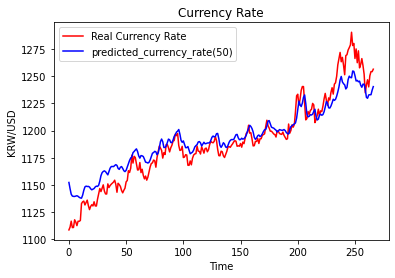

In [ ]:
# Visualising the results
plt.plot(real_currency_rate, color = 'red', label = 'Real Currency Rate')
plt.plot(predicted_currency_rate_50, color = 'blue', label = 'predicted_currency_rate(50)')
plt.title('Currency Rate')
plt.xlabel('Time')
plt.ylabel("KRW/USD")
plt.legend(loc='best')
plt.show()